# Customer Segmentation Practice Project (K-Prototypes) — Credit Card Behavior

## Notebook Summary
- Goal: segment credit-card customers using **mixed data** (categorical + numeric) to support **targeting and resource allocation**.
- Method: **K-Prototypes** clustering + **elbow chart** to select k, then segment profiling to translate clusters into business actions.
- Key pitfall fixed: **ID leakage** (including `CUST_ID` can distort clustering). I show a quick comparison and keep the final model **ID-free**.
- Output: **4 segments** with sizes + KPI profiles; one segment represents a **high-value / high-priority** group for retention and service.
- Deliverable: ends with a short **business-style report** translating the segmentation into decisions (who to prioritize + how).

## Data & Features (aligned with the original dataset structure)
- Identifier: `CUST_ID` (used only for joining / reporting, **not** for clustering)
- Categorical: `GENDER`
- Continuous: `BALANCE`, `PURCHASES`, `CREDIT_LIMIT`, `PAYMENTS`, `PRC_FULL_PAYMENT`

## Notes on data usage
This project was originally built on a course dataset provided by **Prof. Tianxin Zou (University of Florida)**.  
To avoid sharing course-provided raw data, the public GitHub version uses a **synthetic dataset** with the same schema and realistic ranges. The workflow and results interpretation remain the same.


## Load and normalize data

In [ ]:
# importing packages
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
# importing data and renaming variables
url = "https://raw.githubusercontent.com/YiLiang0804/Customer-segmentation-kprototypes-creditcard/main/data/synthetic_creditcard_behavior.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUST_ID           1000 non-null   int64  
 1   GENDER            1000 non-null   object 
 2   BALANCE           1000 non-null   float64
 3   PURCHASES         1000 non-null   float64
 4   CREDIT_LIMIT      1000 non-null   int64  
 5   PAYMENTS          1000 non-null   float64
 6   PRC_FULL_PAYMENT  1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB


In [43]:
ID_COL = "CUST_ID"
CAT_COLS = ["GENDER"]
NUM_COLS = ["BALANCE", "PURCHASES", "CREDIT_LIMIT", "PAYMENTS", "PRC_FULL_PAYMENT"]

features_in_model = [ID_COL] + CAT_COLS + NUM_COLS  # <-- show the wrong draft explicitly
pd.DataFrame({"features_used_in_draft": features_in_model})


,features_used_in_draft
0,CUST_ID
1,GENDER
2,BALANCE
3,PURCHASES
4,CREDIT_LIMIT
5,PAYMENTS
6,PRC_FULL_PAYMENT


CUST_ID is an identifier, so I need to removed it from the feature set before clustering.

In [44]:
# Drop CUST_ID and encode GENDER
df_work = df.copy()
df_work['GENDER'] = df_work['GENDER'].map({'M': 0, 'F': 1})  # 0=male, 1=female

# Normalize numerical columns
numerical_cols = ["BALANCE", "PURCHASES", "CREDIT_LIMIT", "PAYMENTS", "PRC_FULL_PAYMENT"]
scaler = StandardScaler()
df_work[numerical_cols] = scaler.fit_transform(df_work[numerical_cols])

# Drop CUST_ID for clustering
df_for_clustering = df_work.drop(columns=['CUST_ID'])

display(df_for_clustering.head())

,GENDER,BALANCE,PURCHASES,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT
0,0,-0.760651,-0.510300,-1.195450,-0.564213,-0.556952
1,0,0.079316,-0.329424,0.223800,-0.470525,-0.556952
2,0,-0.140115,-0.135723,0.223800,-0.605067,-0.556952
3,0,-0.102798,-0.179949,-1.020773,-0.321090,-0.556952
4,0,-0.553026,1.356606,1.533877,0.811564,2.518587


To validate the ID-leakage concern, I compared K-Prototypes results with and without CUST_ID, checking whether clusters were driven by customer behavior rather than arbitrary identifiers.

In [45]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import numpy as np

def run_kprototypes(df_input, k=4, cat_index=0, seed=42):
    # df_input columns: [categorical first] + numeric columns
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df_input[NUM_COLS].values)

    X = np.column_stack([df_input["GENDER"].values, X_num])
    model = KPrototypes(n_clusters=k, n_init=20, random_state=seed, verbose=0)
    labels = model.fit_predict(X, categorical=[cat_index])
    return labels, model.cost_


In [46]:
# Draft (wrong): include ID by appending it as numeric (demonstration only)
df_draft = df.copy()
draft_num_cols = ["CUST_ID"] + NUM_COLS

scaler = StandardScaler()
X_num_draft = scaler.fit_transform(df_draft[draft_num_cols].values)
X_draft = np.column_stack([df_draft["GENDER"].values, X_num_draft])

model_draft = KPrototypes(n_clusters=4, n_init=20, random_state=42, verbose=0)
labels_draft = model_draft.fit_predict(X_draft, categorical=[0])

# Final (fixed)
labels_final, cost_final = run_kprototypes(df, k=4, cat_index=0, seed=42)

print("Draft cost (ID included):", model_draft.cost_)
print("Final cost (ID dropped):", cost_final)

print("\nCluster sizes (draft):")
print(pd.Series(labels_draft).value_counts().sort_index())

print("\nCluster sizes (final):")
print(pd.Series(labels_final).value_counts().sort_index())


Draft cost (ID included): 3222.836701815963
Final cost (ID dropped): 2262.928109315256

Cluster sizes (draft):
0     11
1    655
2    167
3    167
Name: count, dtype: int64

Cluster sizes (final):
0    194
1    169
2    626
3     11
Name: count, dtype: int64


In [47]:
tmp = df.copy()
tmp["seg_draft"] = labels_draft
tmp["seg_final"] = labels_final

print("Draft (ID included) — CUST_ID range by cluster")
display(tmp.groupby("seg_draft")["CUST_ID"].agg(["min","max","mean","count"]))

print("Final (ID dropped) — CUST_ID range by cluster")
display(tmp.groupby("seg_final")["CUST_ID"].agg(["min","max","mean","count"]))


Draft (ID included) — CUST_ID range by cluster


,min,max,mean,count
seg_draft,,,,
0,104,951,539.272727,11
1,1,1000,521.439695,655
2,13,979,348.359281,167
3,5,999,567.958084,167


Final (ID dropped) — CUST_ID range by cluster


,min,max,mean,count
seg_final,,,,
0,13,994,409.386598,194
1,5,999,557.130178,169
2,1,1000,512.766773,626
3,104,951,539.272727,11


In [48]:
df_compare = df.copy()
df_compare["segment_final"] = labels_final

profile = df_compare.groupby("segment_final")[NUM_COLS].mean()
sizes = df_compare["segment_final"].value_counts().sort_index()

display(profile)
display(sizes)


,BALANCE,PURCHASES,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT
segment_final,,,,,
0,5945.593281,3331.158691,11055.927835,5543.889265,0.031654
1,260.367894,2762.331195,8157.218935,2828.061024,0.836443
2,1307.405676,1190.245564,4403.514377,1340.032094,0.044009
3,6292.187906,31833.076000,17727.272727,29400.503882,0.549242


segment_final
0    194
1    169
2    626
3     11
Name: count, dtype: int64

In [49]:
seeds = [0, 1, 2, 3, 4]
rows = []

for s in seeds:
    labels_s, cost_s = run_kprototypes(df, k=4, cat_index=0, seed=s)
    shares = pd.Series(labels_s).value_counts(normalize=True).values
    shares_sorted = np.sort(shares)[::-1]  # descending

    rows.append({
        "seed": s,
        "cost": cost_s,
        "largest_share": shares_sorted[0],
        "share_2nd": shares_sorted[1],
        "share_3rd": shares_sorted[2],
        "smallest_share": shares_sorted[3],
    })

stability_sorted = pd.DataFrame(rows)
display(stability_sorted)


,seed,cost,largest_share,share_2nd,share_3rd,smallest_share
0,0,2262.928109,0.626,0.194,0.169,0.011
1,1,2274.332582,0.621,0.195,0.166,0.018
2,2,2261.382889,0.639,0.182,0.168,0.011
3,3,2262.928109,0.626,0.194,0.169,0.011
4,4,2274.332582,0.621,0.195,0.166,0.018


Across 5 random seeds, the solution is reasonably stable: the clustering cost stays within a narrow range (~2261–2274), and the segment size pattern is consistent (one large segment ~62–64%, one very small segment ~1–2%, and two mid-sized segments ~16–20%). Segment labels may permute across runs, which is expected in clustering.

## Generate elbow chart

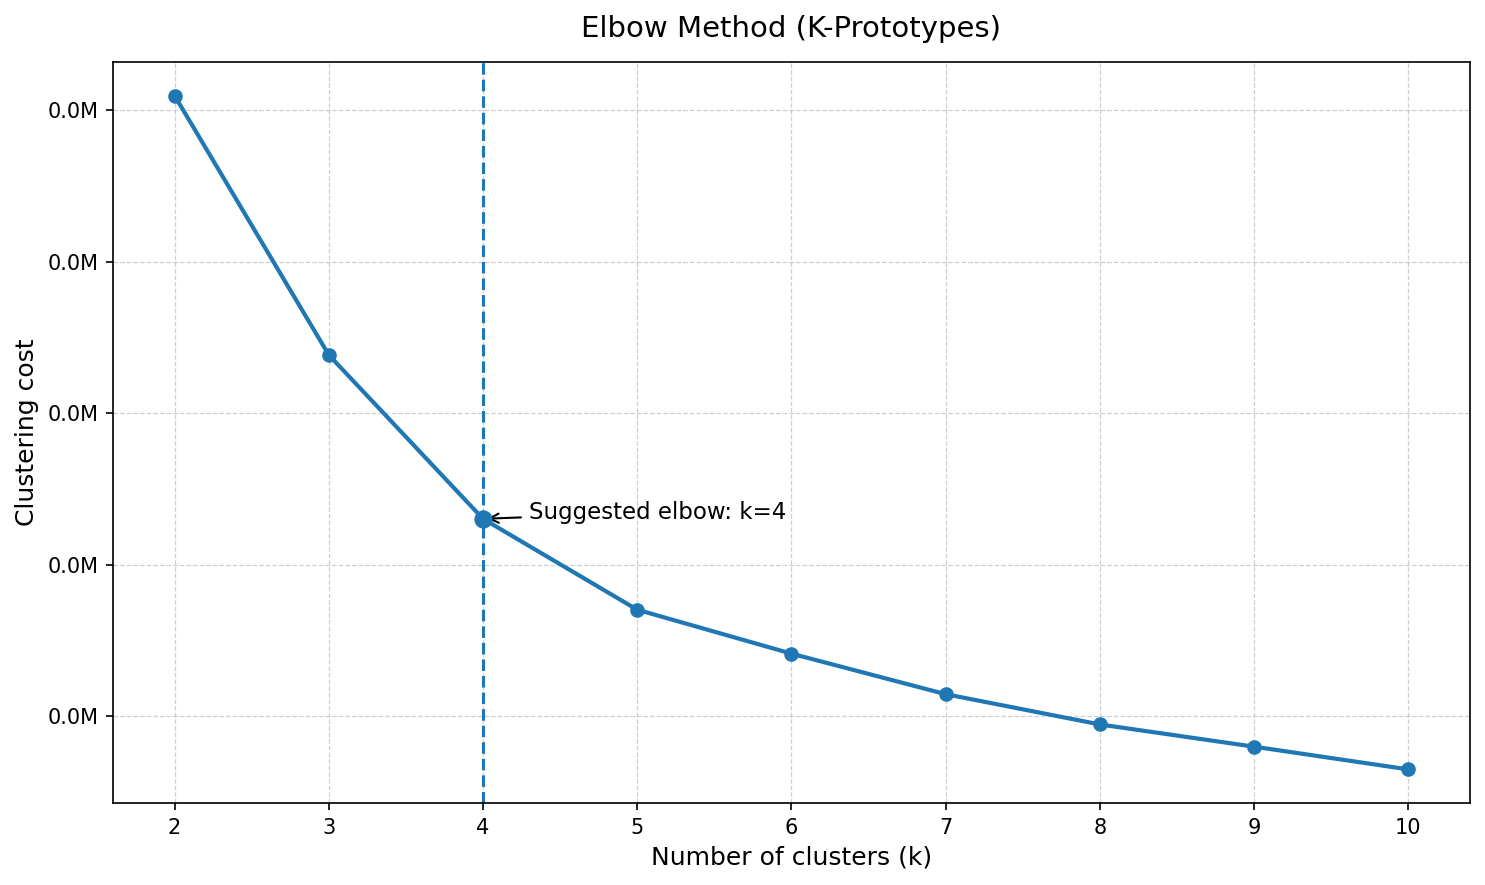

In [50]:
from matplotlib.ticker import FuncFormatter
# Elbow method to determine the optimal number of clusters
# ----------------------------
# 1) Compute costs for k=2..K
# ----------------------------
K_MAX = 10
ks = np.arange(2, K_MAX + 1)

costs = []
for k in ks:
    model = KPrototypes(n_clusters=k, n_init=20, random_state=42, verbose=0)
    result = model.fit(df_for_clustering, categorical=[1])
    costs.append(result.cost_)

costs = np.array(costs)

# -----------------------------------------
# 2) Simple elbow suggestion (2nd diff)
# -----------------------------------------
# For a decreasing curve, the "elbow" often corresponds to the largest change in slope.
# Use second differences as a lightweight heuristic (works well for typical elbow charts).
if len(costs) >= 3:
    second_diff = np.diff(costs, n=2)             # length = len(costs)-2
    elbow_idx = np.argmax(np.abs(second_diff)) + 2  # +2 maps to ks index (k starts at 2)
    k_elbow = ks[elbow_idx]
else:
    k_elbow = None

# -----------------------------------------
# 3) Plot with BA-friendly styling
# -----------------------------------------
plt.figure(figsize=(10, 6), dpi=150)

plt.plot(ks, costs, marker="o", linewidth=2)
plt.xticks(ks)

plt.title("Elbow Method (K-Prototypes)", fontsize=14, pad=12)
plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Clustering cost", fontsize=12)

# light grid improves readability
plt.grid(True, which="major", axis="both", linestyle="--", linewidth=0.6, alpha=0.6)

# format y-axis into millions for readability (adjust if your scale differs)
def millions(x, pos):
    return f"{x/1_000_000:.1f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# annotate elbow suggestion
if k_elbow is not None:
    y_elbow = costs[np.where(ks == k_elbow)[0][0]]
    plt.axvline(k_elbow, linestyle="--", linewidth=1.5)
    plt.scatter([k_elbow], [y_elbow], s=60, zorder=5)
    plt.annotate(
        f"Suggested elbow: k={k_elbow}",
        xy=(k_elbow, y_elbow),
        xytext=(k_elbow + 0.3, y_elbow),
        textcoords="data",
        fontsize=11,
        arrowprops=dict(arrowstyle="->", linewidth=1.0),
    )

plt.tight_layout()

# plt.savefig("outputs/elbow_kprototypes.png", bbox_inches="tight")

plt.show()

## Segment consumers into the optimal number of segments

In [51]:
# Fit the final k-prototypes model with the chosen number of clusters
kprotoSpec = KPrototypes(n_clusters = 4, n_init = 20)  # setup the k-mean model specs with 4 clusters (based on the elbow chart) and 20 initializations
kproto_result = kprotoSpec.fit(df_for_clustering,categorical = [1])    # apply the above model to the normalized data, specifying the index of the categorical column, and store the result

## Post-segmentation analysis

In [52]:
df_out = df.copy()                 
df_out["segment"] = labels_final   

summary = df_out.groupby("segment").agg(
    male_share=("GENDER", lambda x: (x=="M").mean()),
    BALANCE_mean=("BALANCE","mean"),
    PURCHASES_mean=("PURCHASES","mean"),
    CREDIT_LIMIT_mean=("CREDIT_LIMIT","mean"),
    PAYMENTS_mean=("PAYMENTS","mean"),
    PRC_FULL_PAYMENT_mean=("PRC_FULL_PAYMENT","mean"),
    n=("segment","size")
)

display(summary)


,male_share,BALANCE_mean,PURCHASES_mean,CREDIT_LIMIT_mean,PAYMENTS_mean,PRC_FULL_PAYMENT_mean,n
segment,,,,,,,
0,0.402062,5945.593281,3331.158691,11055.927835,5543.889265,0.031654,194
1,0.550296,260.367894,2762.331195,8157.218935,2828.061024,0.836443,169
2,0.506390,1307.405676,1190.245564,4403.514377,1340.032094,0.044009,626
3,0.636364,6292.187906,31833.076000,17727.272727,29400.503882,0.549242,11


In [53]:
# 1) Build a clean output dataframe (raw df + final labels)
df_out = df.copy()
df_out["segment"] = labels_final   # this must be the same labels used in your summary table

# Quick sanity check: segment sizes should match the summary table
print(df_out["segment"].value_counts().sort_index())


segment
0    194
1    169
2    626
3     11
Name: count, dtype: int64


In [54]:
# 2) VIP segment = segment 3 (n should be 11)
vip_df = df_out[df_out["segment"] == 3]

num_vip = vip_df.shape[0]
num_female_vip = (vip_df["GENDER"] == "F").sum()
num_male_vip = (vip_df["GENDER"] == "M").sum()
total_payments_vip = vip_df["PAYMENTS"].sum()

print(f"VIP customers (segment 3): {num_vip}")
print(f"Female: {num_female_vip} | Male: {num_male_vip}")
print(f"Total PAYMENTS (VIP): {total_payments_vip:.2f}")

VIP customers (segment 3): 11
Female: 4 | Male: 7
Total PAYMENTS (VIP): 323405.54


Final insights & recommendations (business summary)

Overall segmentation (k=4):
The model separates customers into four actionable groups with clearly different spending, credit capacity, and payment behaviors. This enables differentiated targeting instead of “one-size-fits-all” campaigns.

Segment 3 — VIP / High-value customers (n=11, highest priority)

This is a small but extremely valuable segment with the strongest business impact per customer. Compared with other segments, these customers show the highest average BALANCE (~6,292), highest PURCHASES (~31,833), highest CREDIT_LIMIT (~17,727), and highest PAYMENTS (~29,401). They also have a relatively higher PRC_FULL_PAYMENT (~0.55), suggesting stronger repayment ability and lower credit risk than what their spend level alone would imply.

Why they matter:
Even though they are only ~1.1% of customers (11/1000), they represent a disproportionate share of transaction volume and payment dollars. From a business perspective, this group should be treated as a retention-and-growth segment rather than a generic marketing audience.

Recommended actions (VIP strategy):

- Retention first: priority service, proactive outreach, and early renewal/upgrade offers to prevent churn.

- Premium upsell: invite-only benefits, higher-tier card perks, and tailored offers aligned with high purchase volume.

- Credit management: consider pre-approved credit line increases or flexible repayment options, while monitoring utilization patterns to manage exposure.

- Personalized engagement: limit irrelevant promotions; focus on high-ROI, high-margin categories and relationship-building campaigns.

Operational note:
Given the small sample size (n=11), I would monitor this segment over time and re-run segmentation periodically to confirm it remains consistent and not driven by transient behavior.

Decision: prioritize Segment 3 for retention and premium upsell, and allocate dedicated relationship-management resources.